In [24]:
# Extracting layer frames from timelapse video.
import os
import sys
import cv2
import PIL
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from multiprocessing.pool import ThreadPool
from collections import deque

from scipy.signal import find_peaks

root_path = "../"

print(cv2.__version__)

4.5.3


In [22]:
# Load video.
data_path = "../video"
filename = "timelapse_raw.mp4"
export_name = "timelapse_export.mp4"
template = "template.png"
rotate_degree = 0

# Open video file.
cap = cv2.VideoCapture(os.path.join(data_path, filename))

# Get metadata.
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("Total frames: {}".format(total_frames))
print("Frame rate: {} FPS".format(frame_rate))
print("Resolution: {} x {}".format(frame_width, frame_height))

Total frames: 8740
Frame rate: 30 FPS
Resolution: 1920 x 1080


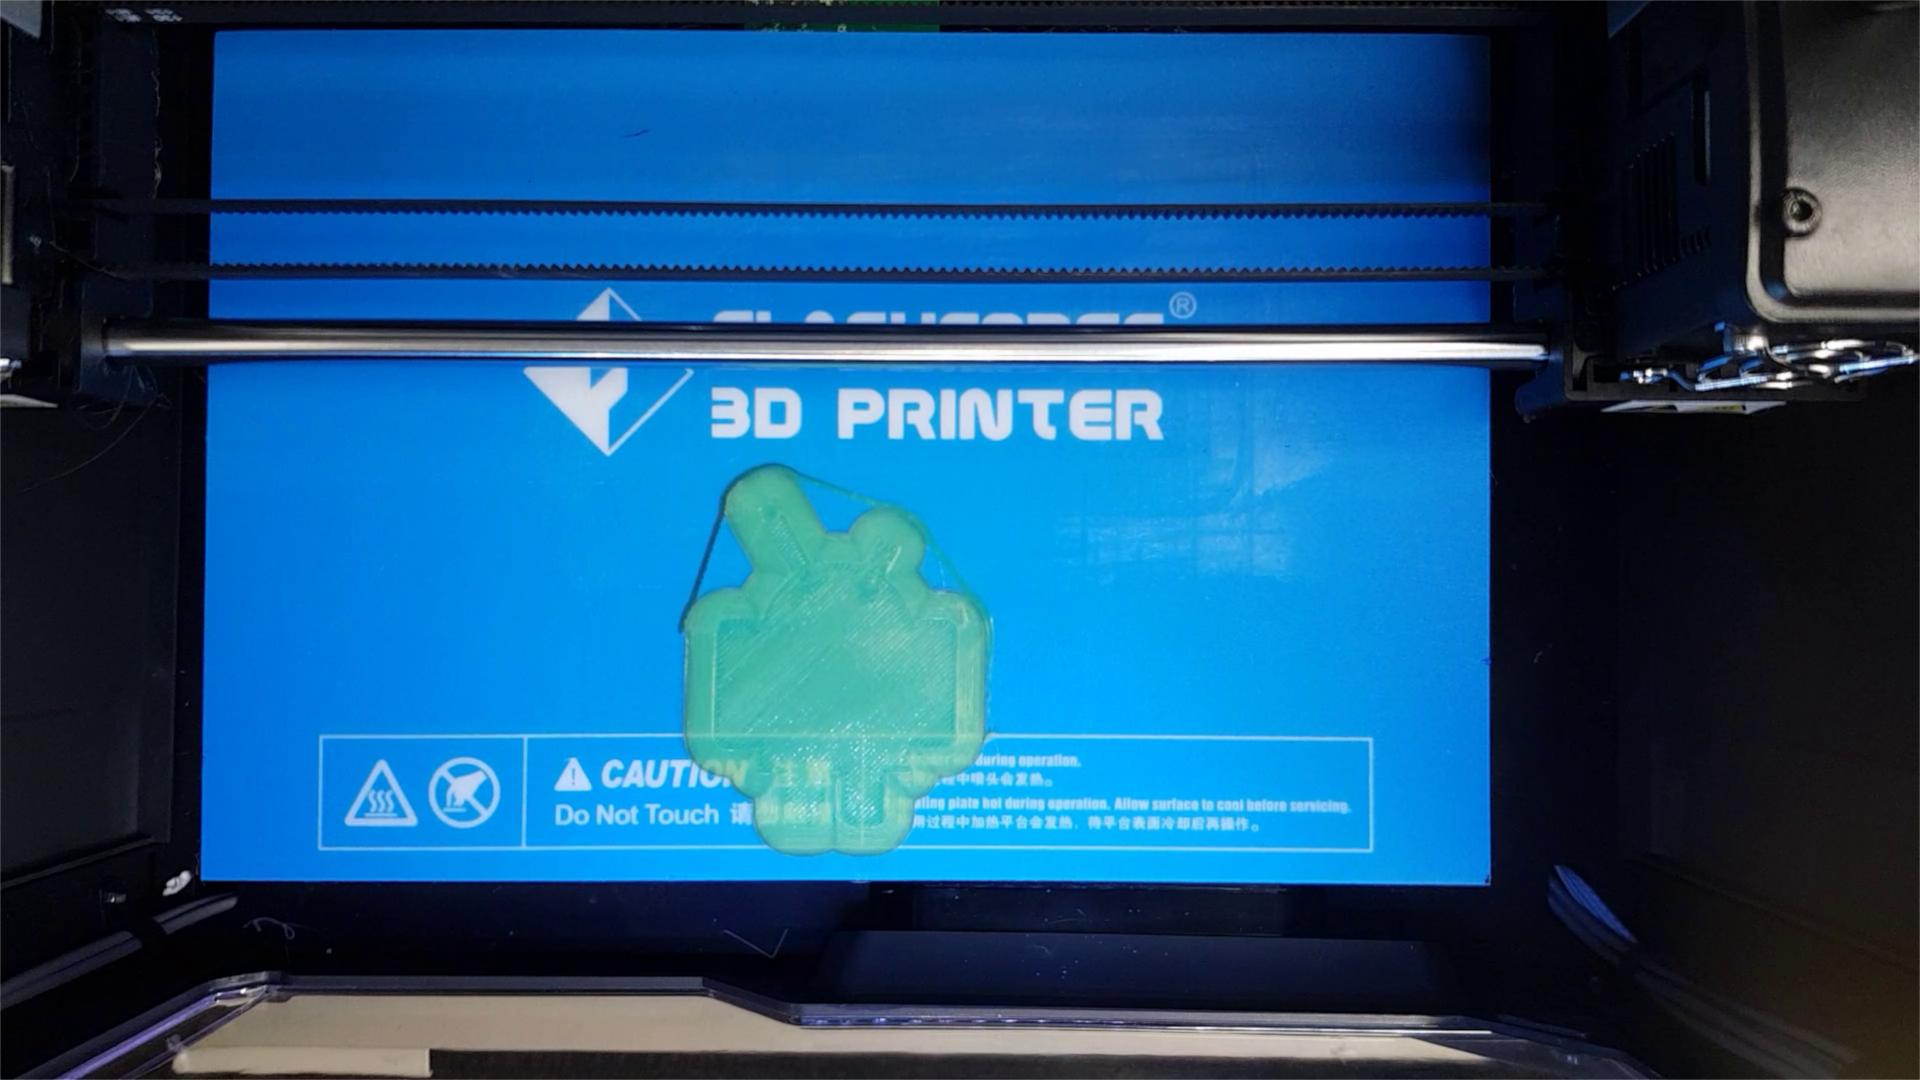

RGBA


In [23]:
# Load template image.
img_template = PIL.Image.open(os.path.join(data_path, template)).rotate(rotate_degree)
display(img_template)
print(img_template.mode)

# Convert to opencv.
img_template = np.array(img_template)
img_template = cv2.cvtColor(img_template, cv2.COLOR_RGB2BGR)

# Crop.
x_start = 0
x_end = int(frame_width / 1)
y_start = 0
y_end = int(frame_height / 1)

In [4]:
def calculate_match_score(idx_match, frame_to_match, template_to_match):
    
    match_score = cv2.matchTemplate(frame_to_match, template_to_match, cv2.TM_CCOEFF)
    
    return idx_match, match_score

In [5]:
# Analyzing frame-by-frame.

# Stats.
all_match_scores = np.zeros(total_frames)

# Init multi-threading.
num_threads = cv2.getNumberOfCPUs()
pool = ThreadPool(processes=num_threads)
pending = deque()

# Interating.
video_bar = ProgressBar(max_value=total_frames)
idx_frame = 0
num_frame_extracted = 0
cap.set(cv2.CAP_PROP_POS_MSEC, 0)
while cap.isOpened():
    
    # Get results.
    while len(pending) > 0 and pending[0].ready():
        idx_match, match_score = pending.popleft().get()
        all_match_scores[idx_match] = match_score
    
    # Apply tasks
    if len(pending) < num_threads:
    
        # Read one frame.
        ret, frame = cap.read()

        if ret:

            # Update progress.
            video_bar.update(idx_frame+1)

            # Apply task.
            task = pool.apply_async(calculate_match_score, 
                                    (idx_frame, 
                                     frame[y_start:y_end, x_start:x_end], 
                                     img_template[y_start:y_end, x_start:x_end]))
            pending.append(task)
            
            # Update index.
            idx_frame += 1

        else:
            break
cap.release()

100% (8740 of 8740) |####################| Elapsed Time: 0:05:54 ETA:  00:00:00

28 peaks found.


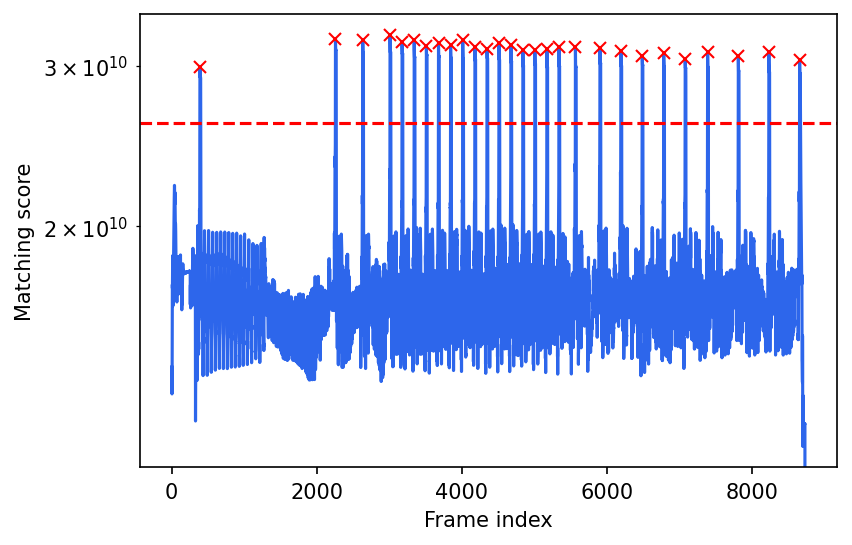

In [21]:
# Show match scores.
vertical_threshold = all_match_scores.max() * 0.801
all_match_scores = np.array(np.array(all_match_scores).flat)

#  plot.
fig, ax = plt.subplots(dpi=150)
ax.set_yscale("log")
ax.set_xlabel("Frame index")
ax.set_ylabel("Matching score")
ax.plot(all_match_scores, color="#2d66eb")
ax.axhline(vertical_threshold, ls="--", color="r")

# Find peaks
idx_peaks, _ = find_peaks(all_match_scores, distance=20, height=vertical_threshold)
ax.plot(idx_peaks, all_match_scores[idx_peaks], "rx")

# For exporting.
idx_frames_included = list(idx_peaks)
print("{} peaks found.".format(len(idx_frames_included)))

In [13]:
# Extracing frames.

# Config.
layer_offset = 0 # Note Layer 0 is the pre-extrusion.
export_frame_rate = 60
layers_per_sec = 5
duplicated_frames = int(export_frame_rate / layers_per_sec)
final_frame_length_sec = 3

# Init output.
# Check export file.
export_path = os.path.join(data_path, export_name)
if os.path.exists(export_path):
    raise FileExistsError("Error: export file {} exits.".format(export_path))
iter_frames = iter(idx_frames_included)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(export_path, fourcc, export_frame_rate, (frame_width, frame_height))

# Open video file.
cap = cv2.VideoCapture(os.path.join(data_path, filename))

# Interating.
cap.set(cv2.CAP_PROP_POS_MSEC, 0)
video_bar = ProgressBar(max_value=total_frames)
idx_frame = 0
idx_layer = 0
next_frame = next(iter_frames)
while cap.isOpened():
    
    # Read one frame.
    ret, frame = cap.read()
    
    if ret:
        
        # Update progress.
        video_bar.update(idx_frame+1)
        
        # Include frame.
        if idx_frame == next_frame:
            
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_rgb = PIL.Image.fromarray(frame_rgb)
            draw = ImageDraw.Draw(frame_rgb)
            fnt = ImageFont.truetype(os.path.join(root_path, "./src/FreeSans.otf"), 60)
            draw.text((frame_rgb.size[0] * 0.6, frame_rgb.size[1] * 0.08), 
                      "Layer: {:>3d}".format(idx_layer+layer_offset), font=fnt, fill=(255,255,255,255))
            frame_bgr = cv2.cvtColor(np.array(frame_rgb), cv2.COLOR_BGR2RGB)
            
            for idx_duplicated in range(duplicated_frames):
                
                out.write(frame_bgr)
            
            try:
                next_frame = next(iter_frames)
                idx_layer += 1
            except StopIteration as e:
                break
        
        idx_frame += 1
        
    else:
        break

# Extend final scene.
for idx_final_scene_duplicate in range(final_frame_length_sec * export_frame_rate):
    out.write(frame_bgr)

cap.release()
out.release()

 98% (8647 of 8740) |################### | Elapsed Time: 0:00:56 ETA:   0:00:00